# Velocity Verlet algorithm in Molecular dynamics 

24 October, 2019

### Basics about Molecular dynamics

We can use Newton's second law to describe the motion of the particles through time.<br>
<br>
$ F = - \frac{dE}{dx} = -\nabla E(r)$

###### Lennard-Jones potential
<br>
$ E_{LJ}(r) = 4\epsilon  [(\frac{\sigma}{r})^{12} - (\frac{\sigma}{r})^6]$

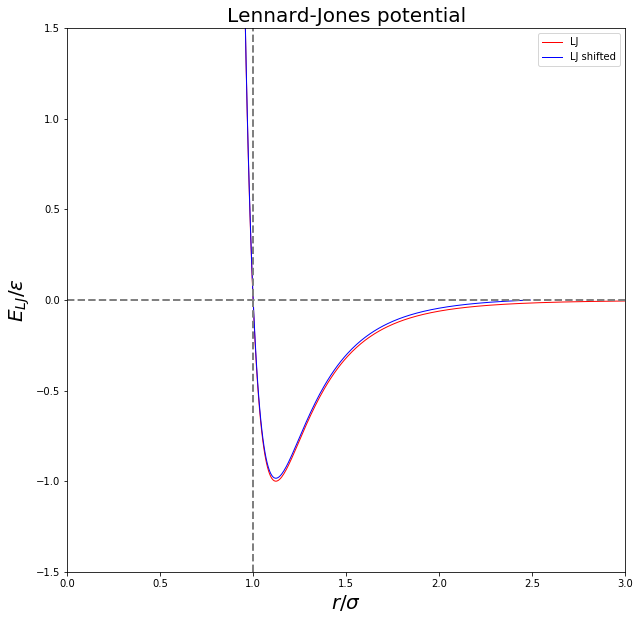

In [66]:
#Import a plotting libraries and a maths library 
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
from timeit import default_timer
import matplotlib.animation as animation

r = np.linspace(0.01, 3.0, num = 500) # Make a radius vector
epsilon = 1 # Energy minimum
sigma = 1 # Distance to zero crossing point
E_LJ = 4*epsilon*((sigma/r)**12-(sigma/r)**6) # Lennard-Jones potential

plt.figure(figsize = [10,10])
plt.plot(r, E_LJ, 'r-', linewidth = 1, label = 'LJ') # Red line is unshifted LJ

# The cutoff and shifting value
Rcutoff = 2.5
phicutoff = 4.0/(Rcutoff**12)-4.0/(Rcutoff**6) # Shifts the potential so at the cutoff the potential goes to zero

E_LJ_shift = E_LJ - phicutoff # Subtract the value of the potential at r=2.5

plt.plot(r[:415], E_LJ_shift[:415], 'b-', linewidth = 1, label = 'LJ shifted') # Blue line is shifted

#Plot formatting
plt.title('Lennard-Jones potential', fontsize=20)
plt.xlim([0.0,3.0])
plt.ylim([-1.5,1.5])
plt.ylabel('$E_{LJ}/\epsilon$', fontsize=20)
plt.xlabel('$r/\sigma$', fontsize=20)
plt.legend()
plt.axhline(0, color = 'grey', linestyle = '--', linewidth = 2)
plt.axvline(1, color = 'grey', linestyle = '--', linewidth = 2)

##### Reduced units

By choosing our units we can remove any constants and get a general behaviour for all gases. Mass, sigma, epsilon and the Boltzmann constant are set to equal one. Reduced coordinates are used for the other variables which are derived from the parameters set to one.

![image](./form.png)

##### Periodic boundary conditions

The green particle moves past the top boundary of the unit cell and are moved to the bottom of the box with the same velocity (illustrated by the red dashed line). This boundary condition keeps the volume and number of particles constant in the simulation.

![image](./bond.png)

## The main steps in a molecular dynamics simulation

1. Initialise the position of particles
2. Calculate the pairwise forces on the particles by calculating the gradient of the potential energy $ F=\nabla E(r)=\frac {1}{dx}\frac{dE}{dx}$
3. Compute the new positions by integrating the equation of motion (we will use the velocity Verlet algorithm)
4. Apply a thermostat to maintain the temperature at the set value (we will use the velocity scaling for temperature control)
5. Go back to step 2, recompute the forces and continue until the maximum number of steps

### Calculating the forces

![image](./force.png)

In [67]:
def Compute_Forces(pos,acc,ene_pot,epsilon,BoxSize,DIM,N):
    # Compute forces on positions using the Lennard-Jones potential
    # Uses double nested loop which is slow O(N^2) time unsuitable for large systems
    Sij = np.zeros(DIM) # Box scaled units
    Rij = np.zeros(DIM) # Real space units
    
    #Set all variables to zero
    ene_pot = ene_pot*0.0
    acc = acc*0.0
    virial=0.0
    
    # Loop over all pairs of particles
    for i in range(N-1):
        for j in range(i+1,N): #i+1 to N ensures we do not double count
            Sij = pos[i,:]-pos[j,:] # Distance in box scaled units
            for l in range(DIM): # Periodic interactions
                if (np.abs(Sij[l])>0.5):
                    Sij[l] = Sij[l] - np.copysign(1.0,Sij[l]) # If distance is greater than 0.5  (scaled units) then subtract 0.5 to find periodic interaction distance.
            
            Rij = BoxSize*Sij # Scale the box to the real units in this case reduced LJ units
            Rsqij = np.dot(Rij,Rij) # Calculate the square of the distance
            
            if(Rsqij < Rcutoff**2):
                # Calculate LJ potential inside cutoff
                # I calculate parts of the LJ potential at a time to improve the efficieny of the computation (most important for compiled code)
                rm2 = 1.0/Rsqij # 1/r^2
                rm6 = rm2**3.0 # 1/r^6
                rm12 = rm6**2.0 # 1/r^12
                phi = epsilon*(4.0*(rm12-rm6)-phicutoff) # 4[1/r^12 - 1/r^6] - phi(Rc) - we are using the shifted LJ potential
                # The following is dphi = -(1/r)(dV/dr)
                dphi = epsilon*24.0*rm2*(2.0*rm12-rm6) # 24[2/r^14 - 1/r^8]
                ene_pot[i] = ene_pot[i]+0.5*phi # Accumulate energy
                ene_pot[j] = ene_pot[j]+0.5*phi # Accumulate energy
                virial = virial - dphi*Rsqij # Virial is needed to calculate the pressure
                acc[i,:] = acc[i,:]+dphi*Sij # Accumulate forces
                acc[j,:] = acc[j,:]-dphi*Sij # (Fji=-Fij)
    return acc, np.sum(ene_pot)/N, -virial/DIM # return the acceleration vector, potential energy and virial coefficient

### Temperature

![image](./temp.png)

In [68]:
def Calculate_Temperature(vel,BoxSize,DIM,N):
    
    ene_kin = 0.0
    
    for i in range(N):
        real_vel = BoxSize*vel[i,:]
        ene_kin = ene_kin + 0.5*np.dot(real_vel,real_vel)
    
    ene_kin_aver = 1.0*ene_kin/N
    temperature = 2.0*ene_kin_aver/DIM
    
    return ene_kin_aver,temperature

### Initialising the particles

In [69]:
DIM = 2 # Dimensions
N = 10

BoxSize = 100.0 

volume  = BoxSize**DIM
density = N / volume
print('volume = ', volume, ' density = ', density)

pos = np.zeros([N,DIM])
        
pos = np.genfromtxt('output.dat',skip_header=1) # Load positions from file
pos = pos[:,:DIM]/BoxSize


MassCentre = np.sum(pos,axis=0)/N

for i in range(DIM):
    pos[:,i] = pos[:,i]-MassCentre[i]

volume =  100.0  density =  0.06


#### Integrating the equations of motion

The velocity Verlet algorithm spilts the velocity update into two steps intially doing a half step then modifing the acceleration and then doing the second velocity update. Written in full, this gives:

1. Calculate $ x(t+Δt)=x(t)+v(t+1/2Δt)Δt$
2. Calculate $ v(t+1/2Δt)=v(t)+1/2a(t)Δt$
3. Derive $a(t+Δt)$ from the interaction potential using $x(t+Δt)$
4. Calculate $v(t+Δt)=v(t+1/2Δt)+1/2a(t+Δt)Δt$
Between step 1 and 2 we rescale the velocities to maintain the temperature at the requested value.

In [70]:
# Setting up the simulation
NSteps=10000 # Number of steps
deltat = 0.0032 # Time step in reduced time units
TRequested = 0.5# #Reduced temperature
DumpFreq = 100 # Save the position to file every DumpFreq steps
epsilon = 1.0 # LJ parameter for the energy between particles

# Main MD loop
def main_plot(pos,NSteps,deltat,TRequested,DumpFreq,epsilon,BoxSize,DIM):
    
    # Vectors to store parameter values at each step
    N = np.size(pos[:,1])
    ene_kin_aver = np.ones(NSteps)
    ene_pot_aver = np.ones(NSteps)
    temperature = np.ones(NSteps)
    virial = np.ones(NSteps)
    pressure = np.ones(NSteps)
    ene_pot = np.ones(N)

    vel = (np.random.randn(N,DIM)-0.5)
    acc = (np.random.randn(N,DIM)-0.5)

    # Open file which we will save the outputs to
    f = open('traj.xyz', 'w')
    
    for k in range(NSteps):
        
        # Refold positions according to periodic boundary conditions
        for i in range(DIM):
            period = np.where(pos[:,i] > 0.5)
            pos[period,i]=pos[period,i]-1.0
            period = np.where(pos[:,i] < -0.5)
            pos[period,i]=pos[period,i]+1.0

        # r(t+dt) modify positions according to velocity and acceleration
        pos = pos + deltat*vel + 0.5*(deltat**2.0)*acc # Step 1

        # Calculate temperature
        ene_kin_aver[k],temperature[k] = Calculate_Temperature(vel,BoxSize,DIM,N)

        # Rescale velocities and take half step
        chi = np.sqrt(TRequested/temperature[k])
        vel = chi*vel + 0.5*deltat*acc # v(t+dt/2) Step 2

        # Compute forces a(t+dt),ene_pot,virial
        acc, ene_pot_aver[k], virial[k] = Compute_Forces(pos,acc,ene_pot,epsilon,BoxSize,DIM,N) # Step 3

        # Complete the velocity step 
        vel = vel + 0.5*deltat*acc # v(t+dt/2) Step 4

        # Calculate temperature
        ene_kin_aver[k],temperature[k] = Calculate_Temperature(vel,BoxSize,DIM,N)

        # Calculate pressure
        pressure[k]= density*temperature[k] + virial[k]/volume
        
        
        # Print output to file every DumpFreq number of steps
        if(k%DumpFreq==0): # The % symbol is the modulus so if the Step is a whole multiple of DumpFreq then print the values

            f.write("%s\n" %(N)) # Write the number of particles to file
            # Write all of the quantities at this step to the file
            f.write("Energy %s, Temperature %.5f\n" %(ene_kin_aver[k]+ene_pot_aver[k],temperature[k]))
            for n in range(N): # Write the positions to file
                f.write("X"+" ")
                for l in range(DIM):
                    f.write(str(pos[n][l]*BoxSize)+" ")
                f.write("\n")
            
            if(DIM==2):
                import matplotlib.pyplot as plt
                from IPython import display
                plt.cla()
                plt.xlim(-0.5*BoxSize,0.5*BoxSize)
                plt.ylim(-0.5*BoxSize,0.5*BoxSize)
                for i in range(N):
                    plt.plot(pos[i,0]*BoxSize,pos[i,1]*BoxSize,'o',markersize=20)
                display.clear_output(wait=True)
                display.display(plt.gcf())
        #print(ene_kin_aver[k], ene_pot_aver[k], temperature[k], pressure[k]) 

    f.close() # Close the file
    
    return ene_kin_aver, ene_pot_aver, temperature, pressure, pos

In [71]:
# Setting up the simulation
NSteps=10000 # Number of steps
deltat = 0.0032 # Time step in reduced time units
TRequested = 0.5# #Reduced temperature
DumpFreq = 100 # Save the position to file every DumpFreq steps
epsilon = 1.0 # LJ parameter for the energy between particles

# Main MD loop
def main(pos,NSteps,deltat,TRequested,DumpFreq,epsilon,BoxSize,DIM):
    
    # Vectors to store parameter values at each step
    N = np.size(pos[:,1])
    ene_kin_aver = np.ones(NSteps)
    ene_pot_aver = np.ones(NSteps)
    temperature = np.ones(NSteps)
    virial = np.ones(NSteps)
    pressure = np.ones(NSteps)
    ene_pot = np.ones(N)

    vel = (np.random.randn(N,DIM)-0.5)
    acc = (np.random.randn(N,DIM)-0.5)

    # Open file which we will save the outputs to
    f = open('traj.xyz', 'w')
    
    for k in range(NSteps):
        
        # Refold positions according to periodic boundary conditions
        for i in range(DIM):
            period = np.where(pos[:,i] > 0.5)
            pos[period,i]=pos[period,i]-1.0
            period = np.where(pos[:,i] < -0.5)
            pos[period,i]=pos[period,i]+1.0

        # r(t+dt) modify positions according to velocity and acceleration
        pos = pos + deltat*vel + 0.5*(deltat**2.0)*acc # Step 1

        # Calculate temperature
        ene_kin_aver[k],temperature[k] = Calculate_Temperature(vel,BoxSize,DIM,N)

        # Rescale velocities and take half step
        chi = np.sqrt(TRequested/temperature[k])
        vel = chi*vel + 0.5*deltat*acc # v(t+dt/2) Step 2

        # Compute forces a(t+dt),ene_pot,virial
        acc, ene_pot_aver[k], virial[k] = Compute_Forces(pos,acc,ene_pot,epsilon,BoxSize,DIM,N) # Step 3

        # Complete the velocity step 
        vel = vel + 0.5*deltat*acc # v(t+dt/2) Step 4

        # Calculate temperature
        ene_kin_aver[k],temperature[k] = Calculate_Temperature(vel,BoxSize,DIM,N)

        # Calculate pressure
        pressure[k]= density*temperature[k] + virial[k]/volume
        
        
        # Print output to file every DumpFreq number of steps
        if(k%DumpFreq==0): # The % symbol is the modulus so if the Step is a whole multiple of DumpFreq then print the values

            f.write("%s\n" %(N)) # Write the number of particles to file
            # Write all of the quantities at this step to the file
            f.write("Energy %s, Temperature %.5f\n" %(ene_kin_aver[k]+ene_pot_aver[k],temperature[k]))
            for n in range(N): # Write the positions to file
                f.write("X"+" ")
                for l in range(DIM):
                    f.write(str(pos[n][l]*BoxSize)+" ")
                f.write("\n")
            
            '''if(DIM==2):
                import matplotlib.pyplot as plt
                from IPython import display
                plt.cla()
                plt.xlim(-0.5*BoxSize,0.5*BoxSize)
                plt.ylim(-0.5*BoxSize,0.5*BoxSize)
                for i in range(N):
                    plt.plot(pos[i,0]*BoxSize,pos[i,1]*BoxSize,'o',markersize=20)
                display.clear_output(wait=True)
                display.display(plt.gcf())'''
        #print(ene_kin_aver[k], ene_pot_aver[k], temperature[k], pressure[k]) 

    f.close() # Close the file
    
    return ene_kin_aver, ene_pot_aver, temperature, pressure, pos

In [45]:
import cProfile
cProfile.run('main(pos,NSteps,deltat,TRequested,DumpFreq,epsilon,BoxSize,DIM)')

Calculate_Temperature time:  2.3700999918219168e-05
Compute_Forces time:  0.00034566600015750737
         2254358 function calls in 4.267 seconds

   Ordered by: standard name

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        6    0.000    0.000    0.000    0.000 <__array_function__ internals>:2(copyto)
   650000    0.187    0.000    0.622    0.000 <__array_function__ internals>:2(dot)
        1    0.000    0.000    0.000    0.000 <__array_function__ internals>:2(size)
    10000    0.005    0.000    0.075    0.000 <__array_function__ internals>:2(sum)
    40000    0.015    0.000    0.040    0.000 <__array_function__ internals>:2(where)
    10000    2.733    0.000    3.262    0.000 <ipython-input-35-faf9b329a39b>:1(Compute_Forces)
    20000    0.293    0.000    0.476    0.000 <ipython-input-36-d15452772281>:1(Calculate_Temperature)
        1    0.483    0.483    4.267    4.267 <ipython-input-41-4b993b703f0b>:10(main_withoutplot)
        1    0.000    0.000

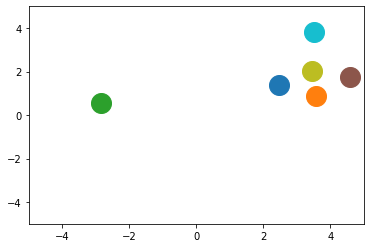

NameError: name 'plot' is not defined

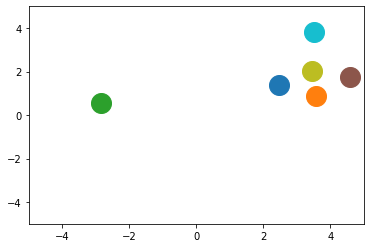

In [72]:
ene_kin_aver, ene_pot_aver, temperature, pressure, pos = main_plot(pos,NSteps,deltat,TRequested,DumpFreq,epsilon,BoxSize,DIM)

'''def plot():
    plt.figure(figsize=[7,12])
    plt.rc('xtick', labelsize=15) 
    plt.rc('ytick', labelsize=15)
    plt.subplot(4, 1, 1)
    plt.plot(ene_kin_aver,'k-')
    plt.ylabel('$E_{K}$', fontsize=20)
    plt.subplot(4, 1, 2)
    plt.plot(ene_pot_aver,'k-')
    plt.ylabel('$E_{P}$', fontsize=20)
    plt.subplot(4, 1, 3)
    plt.plot(temperature,'k-')
    plt.ylabel('T', fontsize=20)
    plt.subplot(4, 1, 4)
    plt.plot(pressure,'k-')
    plt.ylabel('P', fontsize=20)
    plt.show()'''

plot()

In [30]:
print("Temperature = ", np.average(temperature), "+-", 2*np.std(temperature))

Temperature =  2.099612809068363e+48 +- 2.9690039653777313e+50


In [31]:
print("Pressure = ", np.average(pressure), "+-", 2*np.std(pressure))

Pressure =  1.2597676854410178e+47 +- 1.7814023792266375e+49


In [62]:
start = default_timer()
main(pos,NSteps,deltat,TRequested,DumpFreq,epsilon,BoxSize,DIM)
end = default_timer()
print('Time without jit: ', end - start)

Calculate_Temperature time:  5.1140000323357526e-05
Compute_Forces time:  0.0005776729999524832
Time without jit:  4.044191236000188


### JIT 

In [108]:
from numba import jit

In [109]:
@jit
def Compute_Forces_jit(pos,acc,ene_pot,epsilon,BoxSize,DIM,N):
    # Compute forces on positions using the Lennard-Jones potential
    # Uses double nested loop which is slow O(N^2) time unsuitable for large systems
    Sij = np.zeros(DIM) # Box scaled units
    Rij = np.zeros(DIM) # Real space units
    
    #Set all variables to zero
    ene_pot = ene_pot*0.0
    acc = acc*0.0
    virial=0.0
    
    # Loop over all pairs of particles
    for i in range(N-1):
        for j in range(i+1,N): #i+1 to N ensures we do not double count
            Sij = pos[i,:]-pos[j,:] # Distance in box scaled units
            for l in range(DIM): # Periodic interactions
                if (np.abs(Sij[l])>0.5):
                    Sij[l] = Sij[l] - np.copysign(1.0,Sij[l]) # If distance is greater than 0.5  (scaled units) then subtract 0.5 to find periodic interaction distance.
            
            Rij = BoxSize*Sij # Scale the box to the real units in this case reduced LJ units
            Rsqij = np.dot(Rij,Rij) # Calculate the square of the distance
            
            if(Rsqij < Rcutoff**2):
                # Calculate LJ potential inside cutoff
                # I calculate parts of the LJ potential at a time to improve the efficieny of the computation (most important for compiled code)
                rm2 = 1.0/Rsqij # 1/r^2
                rm6 = rm2**3.0 # 1/r^6
                rm12 = rm6**2.0 # 1/r^12
                phi = epsilon*(4.0*(rm12-rm6)-phicutoff) # 4[1/r^12 - 1/r^6] - phi(Rc) - we are using the shifted LJ potential
                # The following is dphi = -(1/r)(dV/dr)
                dphi = epsilon*24.0*rm2*(2.0*rm12-rm6) # 24[2/r^14 - 1/r^8]
                ene_pot[i] = ene_pot[i]+0.5*phi # Accumulate energy
                ene_pot[j] = ene_pot[j]+0.5*phi # Accumulate energy
                virial = virial - dphi*Rsqij # Virial is needed to calculate the pressure
                acc[i,:] = acc[i,:]+dphi*Sij # Accumulate forces
                acc[j,:] = acc[j,:]-dphi*Sij # (Fji=-Fij)
    return acc, np.sum(ene_pot)/N, -virial/DIM # return the acceleration vector, potential energy and virial coefficient

In [110]:
@jit
def Calculate_Temperature_jit(vel,BoxSize,DIM,N):
    
    ene_kin = 0.0
    
    for i in range(N):
        real_vel = BoxSize*vel[i,:]
        ene_kin = ene_kin + 0.5*np.dot(real_vel,real_vel)
    
    ene_kin_aver = 1.0*ene_kin/N
    temperature = 2.0*ene_kin_aver/DIM
    
    return ene_kin_aver,temperature

In [111]:
DIM = 2 # Dimensions
N = 10

BoxSize = 100.0 

volume  = BoxSize**DIM
density = N / volume
print('volume = ', volume, ' density = ', density)

pos = np.zeros([N,DIM])
        
pos = np.genfromtxt('output.dat',skip_header=1) # Load positions from file
pos = pos[:,:DIM]/BoxSize
print(pos)


MassCentre = np.sum(pos,axis=0)/N

for i in range(DIM):
    pos[:,i] = pos[:,i]-MassCentre[i]
print(pos)

volume =  10000.0  density =  0.001
[[-0.02760199 -0.00555414]
 [-0.01875552  0.00100308]
 [-0.00627433 -0.0075519 ]
 [-0.01918781  0.00730312]
 [-0.01919533  0.0075859 ]
 [ 0.00656563  0.00053741]
 [-0.0054725  -0.01386816]
 [-0.00539173 -0.0141688 ]
 [ 0.00574751  0.01264665]
 [ 0.01688277 -0.00586373]]
[[-0.02033366 -0.00376108]
 [-0.01148719  0.00279614]
 [ 0.000994   -0.00575884]
 [-0.01191948  0.00909618]
 [-0.011927    0.00937896]
 [ 0.01383396  0.00233047]
 [ 0.00179583 -0.0120751 ]
 [ 0.0018766  -0.01237574]
 [ 0.01301584  0.01443971]
 [ 0.0241511  -0.00407067]]


In [112]:
# Setting up the simulation
NSteps=10000 # Number of steps
deltat = 0.0032 # Time step in reduced time units
TRequested = 0.5# #Reduced temperature
DumpFreq = 100 # Save the position to file every DumpFreq steps
epsilon = 1.0 # LJ parameter for the energy between particles

# Main MD loop

def main_jit(pos,NSteps,deltat,TRequested,DumpFreq,epsilon,BoxSize,DIM):
    
    # Vectors to store parameter values at each step
    N = np.size(pos[:,1])
    ene_kin_aver = np.ones(NSteps)
    ene_pot_aver = np.ones(NSteps)
    temperature = np.ones(NSteps)
    virial = np.ones(NSteps)
    pressure = np.ones(NSteps)
    ene_pot = np.ones(N)

    vel = (np.random.randn(N,DIM)-0.5)
    acc = (np.random.randn(N,DIM)-0.5)

    # Open file which we will save the outputs to
    f = open('traj.xyz', 'w')
    
    for k in range(NSteps):
        
        # Refold positions according to periodic boundary conditions
        for i in range(DIM):
            period = np.where(pos[:,i] > 0.5)
            pos[period,i]=pos[period,i]-1.0
            period = np.where(pos[:,i] < -0.5)
            pos[period,i]=pos[period,i]+1.0

        # r(t+dt) modify positions according to velocity and acceleration
        pos = pos + deltat*vel + 0.5*(deltat**2.0)*acc # Step 1

        # Calculate temperature
        start1 = default_timer()
        ene_kin_aver[k],temperature[k] = Calculate_Temperature_jit(vel,BoxSize,DIM,N)
        end1 = default_timer()
        #print('Calculate_Temperature_jit time: ', end - start)

        # Rescale velocities and take half step
        chi = np.sqrt(TRequested/temperature[k])
        vel = chi*vel + 0.5*deltat*acc # v(t+dt/2) Step 2

        # Compute forces a(t+dt),ene_pot,virial
        start2 = default_timer()
        acc, ene_pot_aver[k], virial[k] = Compute_Forces_jit(pos,acc,ene_pot,epsilon,BoxSize,DIM,N) # Step 3
        end2 = default_timer()
        #print('Calculate_Forces_jit time: ', end - start)

        # Complete the velocity step 
        vel = vel + 0.5*deltat*acc # v(t+dt/2) Step 4

        # Calculate temperature
        ene_kin_aver[k],temperature[k] = Calculate_Temperature_jit(vel,BoxSize,DIM,N)

        # Calculate pressure
        pressure[k]= density*temperature[k] + virial[k]/volume
        
        
        # Print output to file every DumpFreq number of steps
        if(k%DumpFreq==0): # The % symbol is the modulus so if the Step is a whole multiple of DumpFreq then print the values

            f.write("%s\n" %(N)) # Write the number of particles to file
            # Write all of the quantities at this step to the file
            f.write("Energy %s, Temperature %.5f\n" %(ene_kin_aver[k]+ene_pot_aver[k],temperature[k]))
            for n in range(N): # Write the positions to file
                f.write("X"+" ")
                for l in range(DIM):
                    f.write(str(pos[n][l]*BoxSize)+" ")
                f.write("\n")
            
            '''if(DIM==2):
                import matplotlib.pyplot as plt
                from IPython import display
                plt.cla()
                plt.xlim(-0.5*BoxSize,0.5*BoxSize)
                plt.ylim(-0.5*BoxSize,0.5*BoxSize)
                for i in range(N):
                    plt.plot(pos[i,0]*BoxSize,pos[i,1]*BoxSize,'o',markersize=20)
                display.clear_output(wait=True)
                display.display(plt.gcf())'''
        #print(ene_kin_aver[k], ene_pot_aver[k], temperature[k], pressure[k]) 

    f.close() # Close the file
    print('Calculate_Temperature_jit time: ', end1 - start1)
    print('Compute_Forces_jit time: ', end2 - start2)
    
    return ene_kin_aver, ene_pot_aver, temperature, pressure, pos

In [113]:
start = default_timer()
main_jit(pos,NSteps,deltat,TRequested,DumpFreq,epsilon,BoxSize,DIM)
end = default_timer()
print('Time with jit: ', end - start)

Calculate_Temperature_jit time:  1.8040000213659368e-06
Compute_Forces_jit time:  8.180999429896474e-06
Time with jit:  1.2689126949999263


## CuPy

In [5]:
import cupy as cp
import numpy as np
from timeit import default_timer

In [10]:
def Compute_Forces_cp(pos,acc,ene_pot,epsilon,BoxSize,DIM,N):
    # Compute forces on positions using the Lennard-Jones potential
    # Uses double nested loop which is slow O(N^2) time unsuitable for large systems
    Sij = cp.zeros(DIM) # Box scaled units
    Rij = cp.zeros(DIM) # Real space units
    
    #Set all variables to zero
    ene_pot = ene_pot*0.0
    acc = acc*0.0
    virial=0.0
    
    # Loop over all pairs of particles
    for i in range(N-1):
        for j in range(i+1,N): #i+1 to N ensures we do not double count
            Sij = pos[i,:]-pos[j,:] # Distance in box scaled units
            for l in range(DIM): # Periodic interactions
                if (cp.abs(Sij[l])>0.5):
                    Sij[l] = Sij[l] - cp.copysign(1.0,Sij[l]) # If distance is greater than 0.5  (scaled units) then subtract 0.5 to find periodic interaction distance.
            
            Rij = BoxSize*Sij # Scale the box to the real units in this case reduced LJ units
            Rsqij = cp.dot(Rij,Rij) # Calculate the square of the distance
            
            if(Rsqij < Rcutoff**2):
                # Calculate LJ potential inside cutoff
                # I calculate parts of the LJ potential at a time to improve the efficieny of the computation (most important for compiled code)
                rm2 = 1.0/Rsqij # 1/r^2
                rm6 = rm2**3.0 # 1/r^6
                rm12 = rm6**2.0 # 1/r^12
                phi = epsilon*(4.0*(rm12-rm6)-phicutoff) # 4[1/r^12 - 1/r^6] - phi(Rc) - we are using the shifted LJ potential
                # The following is dphi = -(1/r)(dV/dr)
                dphi = epsilon*24.0*rm2*(2.0*rm12-rm6) # 24[2/r^14 - 1/r^8]
                ene_pot[i] = ene_pot[i]+0.5*phi # Accumulate energy
                ene_pot[j] = ene_pot[j]+0.5*phi # Accumulate energy
                virial = virial - dphi*Rsqij # Virial is needed to calculate the pressure
                acc[i,:] = acc[i,:]+dphi*Sij # Accumulate forces
                acc[j,:] = acc[j,:]-dphi*Sij # (Fji=-Fij)
    return cp.asnumpy(acc), cp.sum(ene_pot)/N, -virial/DIM 

In [11]:
def Calculate_Temperature_cp(vel,BoxSize,DIM,N):
    
    ene_kin = 0.0
    
    for i in range(N):
        real_vel = BoxSize*vel[i,:]
        ene_kin = ene_kin + 0.5*cp.dot(real_vel,real_vel)
    
    ene_kin_aver = 1.0*ene_kin/N
    temperature = 2.0*ene_kin_aver/DIM
    
    return ene_kin_aver, temperature

In [12]:
DIM = 2 # Dimensions
N = 10

BoxSize = 100.0 

volume  = BoxSize**DIM
density = N / volume
print('volume = ', volume, ' density = ', density)

pos = np.zeros([N,DIM])
        
pos = np.genfromtxt('./output.dat',skip_header=1) # Load positions from file
pos = pos[:,:DIM]/BoxSize


MassCentre = np.sum(pos,axis=0)/N

for i in range(DIM):
    pos[:,i] = pos[:,i]-MassCentre[i]

volume =  10000.0  density =  0.001


In [18]:
# Setting up the simulation
NSteps=10000 # Number of steps
deltat = 0.0032 # Time step in reduced time units
TRequested = 0.5# #Reduced temperature
DumpFreq = 100 # Save the position to file every DumpFreq steps
epsilon = 1.0 # LJ parameter for the energy between particles

# Main MD loop
def main_cp(pos,NSteps,deltat,TRequested,DumpFreq,epsilon,BoxSize,DIM):
    
    # Vectors to store parameter values at each step
    N = np.size(pos[:,1])
    ene_kin_aver = np.ones(NSteps)
    ene_pot_aver = np.ones(NSteps)
    temperature = np.ones(NSteps)
    virial = np.ones(NSteps)
    pressure = np.ones(NSteps)
    ene_pot = np.ones(N)

    vel = (np.random.randn(N,DIM)-0.5)
    acc = (np.random.randn(N,DIM)-0.5)

    # Open file which we will save the outputs to
    f = open('traj.xyz', 'w')
    
    for k in range(NSteps):
        
        # Refold positions according to periodic boundary conditions
        for i in range(DIM):
            period = np.where(pos[:,i] > 0.5)
            pos[period,i]=pos[period,i]-1.0
            period = np.where(pos[:,i] < -0.5)
            pos[period,i]=pos[period,i]+1.0

        # r(t+dt) modify positions according to velocity and acceleration
        pos = pos + deltat*vel + 0.5*(deltat**2.0)*acc # Step 1

        # Calculate temperature
        start1 = default_timer()
        ene_kin_aver[k],temperature[k] = Calculate_Temperature_cp(vel,BoxSize,DIM,N)
        end1 = default_timer()
        #print('Calculate_Temperature time: ', end - start)

        # Rescale velocities and take half step
        chi = np.sqrt(TRequested/temperature[k])
        vel = chi*vel + 0.5*deltat*acc # v(t+dt/2) Step 2

        # Compute forces a(t+dt),ene_pot,virial
        start2 = default_timer()
        #acc, ene_pot_aver[k], virial[k] = Compute_Forces(pos,acc,ene_pot,epsilon,BoxSize,DIM,N)
        acc, ene_pot_aver[k], virial[k] = Compute_Forces_cp(cp.asarray(pos),cp.asarray(acc),cp.asarray(ene_pot),epsilon,BoxSize,DIM,N) # Step 3
        end2 = default_timer()
        #print('Compute_Forces time: ', end - start)

        # Complete the velocity step 
        vel = vel + 0.5*deltat*acc # v(t+dt/2) Step 4

        # Calculate temperature
        ene_kin_aver[k],temperature[k] = Calculate_Temperature_cp(cp.asarray(vel),BoxSize,DIM,N)

        # Calculate pressure
        pressure[k]= density*temperature[k] + virial[k]/volume
        
        
        # Print output to file every DumpFreq number of steps
        if(k%DumpFreq==0): # The % symbol is the modulus so if the Step is a whole multiple of DumpFreq then print the values

            f.write("%s\n" %(N)) # Write the number of particles to file
            # Write all of the quantities at this step to the file
            f.write("Energy %s, Temperature %.5f\n" %(ene_kin_aver[k]+ene_pot_aver[k],temperature[k]))
            for n in range(N): # Write the positions to file
                f.write("X"+" ")
                for l in range(DIM):
                    f.write(str(pos[n][l]*BoxSize)+" ")
                f.write("\n")
            
            '''if(DIM==2):
                import matplotlib.pyplot as plt
                from IPython import display
                plt.cla()
                plt.xlim(-0.5*BoxSize,0.5*BoxSize)
                plt.ylim(-0.5*BoxSize,0.5*BoxSize)
                for i in range(N):
                    plt.plot(cp.asnumpy(pos[i,0])*BoxSize,cp.asnumpy(pos[i,1])*BoxSize,'o',markersize=20)
                display.clear_output(wait=True)
                display.display(plt.gcf())'''
        #print(ene_kin_aver[k], ene_pot_aver[k], temperature[k], pressure[k]) 

    f.close() # Close the file
    print('Calculate_Temperature time: ', end1 - start1)
    print('Compute_Forces time: ', end2 - start2)
    
    return ene_kin_aver, ene_pot_aver, temperature, pressure, pos

In [20]:
start = default_timer()
main_cp(pos,NSteps,deltat,TRequested,DumpFreq,epsilon,BoxSize,DIM)
end = default_timer()
print('Time with CuPy: ', end - start)

Calculate_Temperature time:  2.214685082435608e-05
Compute_Forces time:  0.00032440898939967155
Time with CuPy:  15.99495194433257
